- alchemlyb (`pip install git+https://github.com/alchemistry/alchemlyb`)


In [1]:
import safep
import alchemlyb
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from alchemlyb.estimators import BAR
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# User parameters

In [2]:
path='../../alchemtest/src/alchemtest/namd/idws/'
filename='*.fep*'

temperature = 303.15
RT = 0.00198720650096 * temperature

## IMPORTANT: Make sure the temperature above matches the temperature used to run the simulations.

In [3]:
fepoutFiles = glob(path+filename)
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 2 fepout files.
Total size:0.0GB


In [4]:
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
decorrelate = True #Flag for decorrelation of samples
detectEQ = True #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

# Read Data
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [5]:
if totalSize < maxSize:
    u_nk, affix = safep.readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ)
    
else:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}.\nTry the read, decorrelate, save method in the Expanded version of this notebook or increase the maxSize variable above.\nIn the future, consider using less frequent sampling (e.g. every 100 steps).")

Decorrelating samples. Flag='True'
Detecting Equilibrium


# Carry out MBAR Fitting and Analyses

In [6]:
u_nk = u_nk.sort_index(level=1)

In [7]:
bar = BAR()
bar.fit(u_nk)

BAR()

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to convert to units of kcal/mol.

In [8]:
l, l_mid, f, df, ddf, errors = safep.get_BAR(bar)
changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1]*RT, 3)} kcal/mol'
print(changeAndError)

ΔG = 0.1±0.053 kcal/mol


# Plot the change in free energy based on MBAR estimates

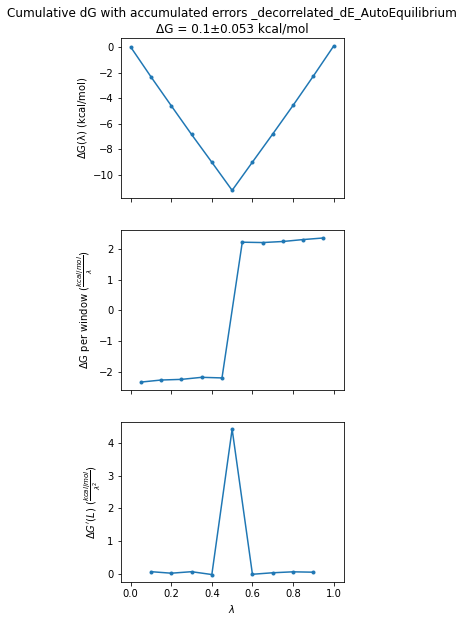

In [9]:
fig, (axCumul, axPerL, axdPerL) = plt.subplots(3,1, sharex=True, figsize=(4,10))
# Cumulative change in kcal/mol
axCumul.errorbar(l, f*RT, yerr=errors*RT, marker='.')
axCumul.set_ylabel(r'$\rm \Delta G(\lambda)$ (kcal/mol)')
axCumul.set_title(f'Cumulative dG with accumulated errors {affix}\n{changeAndError}')

# Per-window change in kcal/mol
axPerL.errorbar(l_mid, df*RT, yerr=ddf*RT, marker='.')
axPerL.set_ylabel(r'$\rm \Delta G$ per window ($\frac{kcal/mol}{\lambda}$)')

# Per-window change in kcal/mol
axdPerL.errorbar(l[1:-1], np.diff(df*RT), marker='.')
axdPerL.set_xlabel(r'$\lambda$')
axdPerL.set_ylabel(r"$\Delta G'(L)$ ($\frac{kcal/mol}{\lambda^2}$)")
plt.savefig(f'{path}dG_data_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

In [10]:
fs, ferr, bs, berr = safep.doConvergence(u_nk)

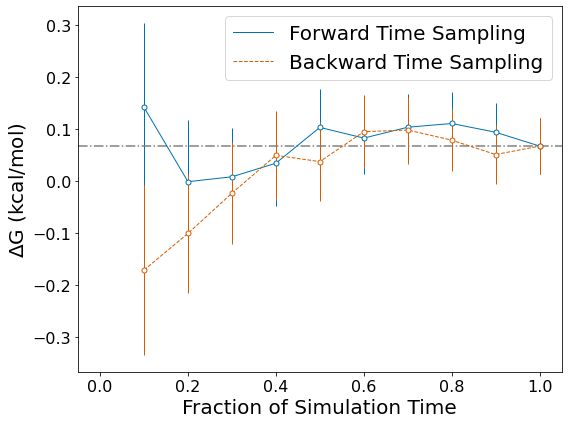

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = safep.convergencePlot(ax, fs*RT, ferr*RT, bs*RT, berr*RT, fwdColor='#0072B2', bwdColor='#D55E00')
ax.legend(fontsize=20)
ax.set_ylabel(r'$\rm\Delta G$ (kcal/mol)', fontsize=20)
ax.set_xlabel('Fraction of Simulation Time', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.tight_layout()
plt.savefig(f'{path}convergence_{affix}.png', dpi=600)
plt.savefig(f'{path}convergence_{affix}.pdf')
plt.savefig(f'{path}FEP_convergence.pdf')

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [13]:
l, l_mid, dG_f, dG_b = safep.get_EXP(u_nk)

# Estimate and plot the Probability Density Function (PDF) for the differences shown above.

Note: you may wish to adjust the numBins parameter below depending on the number of windows you ran in your FEP calculation.

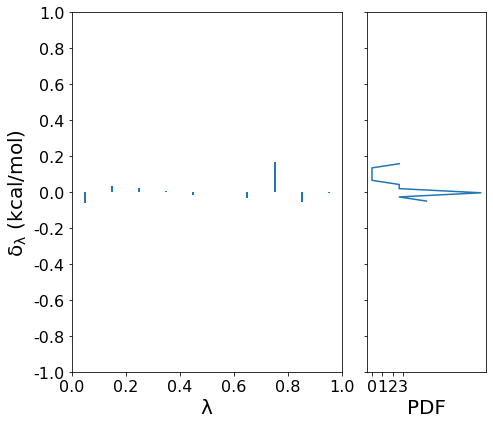

In [15]:
fig, (dAx, pdfAx) = plt.subplots(1,2, figsize=(8,6), sharey=True)
dAx.vlines(l_mid, np.zeros(len(l_mid)), (dG_f + np.array(dG_b))*RT, linewidth=2)

ymin = -1
ymax = 1

dAx.set(ylim=(ymin,ymax))
dAx.set_xlabel(r'$\rm\lambda$', fontsize=20)
dAx.set_ylabel(r"$\rm\delta_\lambda$ (kcal/mol)", fontsize=20)

X, Y, pdfX, pdfY, fitted, pdfXnorm, pdfYnorm, pdfYexpected = safep.getPDF(dG_f, dG_b, binNum=10)
pdfAx.set_xlabel("PDF", fontsize=20)
pdfAx.plot(pdfY, pdfX*RT,  label="Estimated Distribution")
pdfAx.set_box_aspect(3)

dAx.set_xticks(np.round(np.linspace(0,1,6),1))
dAx.set_yticks(np.round(np.linspace(ymin,ymax,11),1))
pdfAx.set_xticks([0,1,2,3])

dAx.set_xticklabels(np.round(np.linspace(0,1,6),1),fontsize=16)
dAx.set_yticklabels(np.round(np.linspace(ymin,ymax,11),1),fontsize=16)
pdfAx.set_xticklabels([0,1,2,3],fontsize=16)

fig.tight_layout(w_pad=-2)
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)
plt.savefig(f'{path}discrepancies_{affix}.pdf')
plt.savefig(f'{path}hysteresis.pdf')